In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input/pancreas-ct'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 18942 DICOM files in the directory.


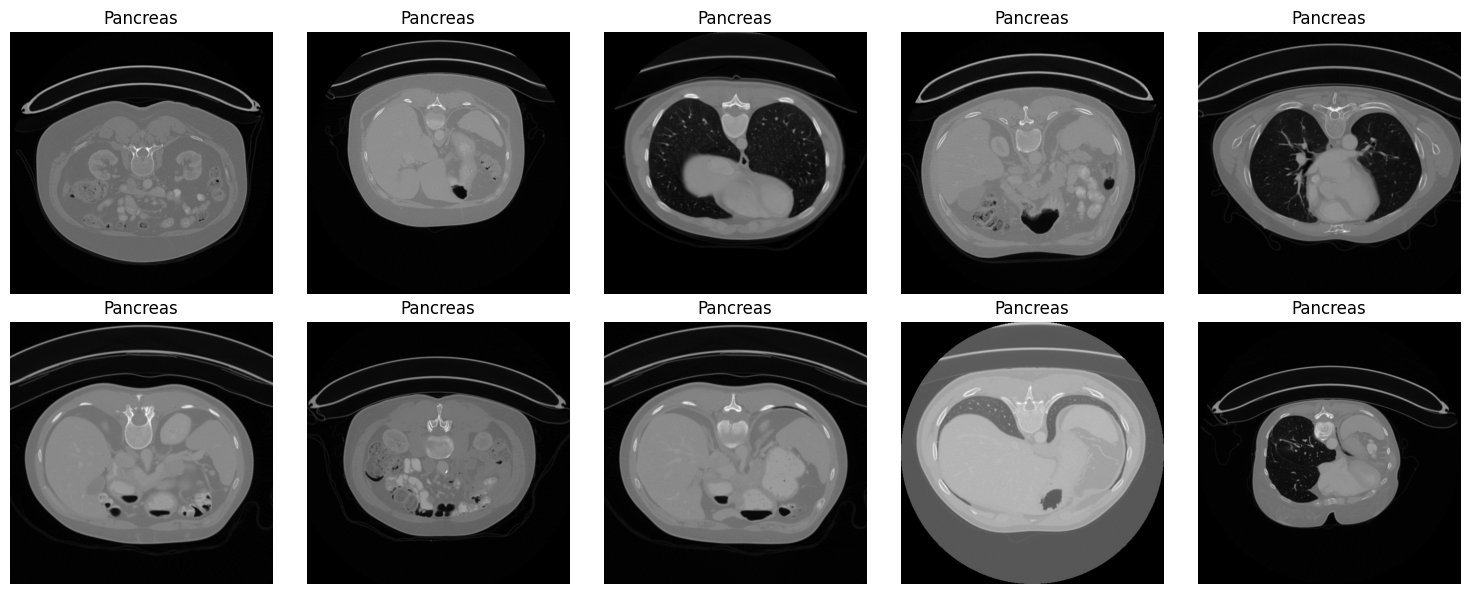

Found 82 NIfTI files in the directory.


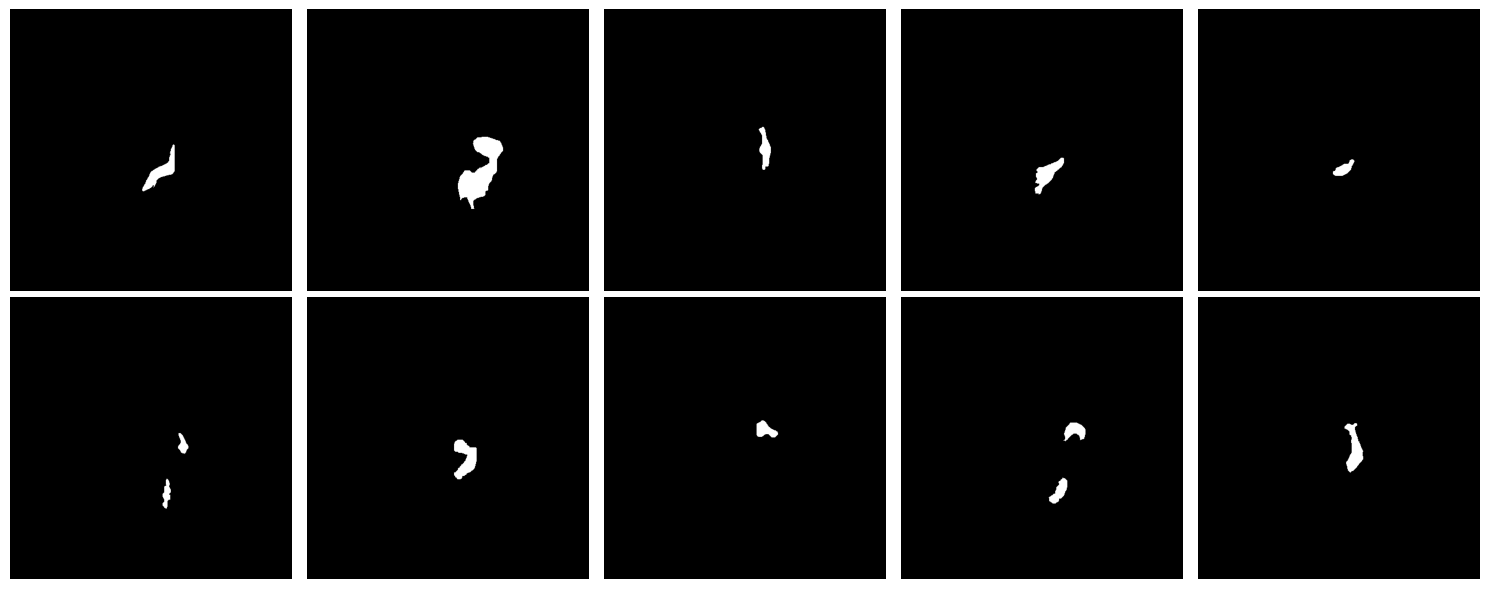

In [2]:
import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt

def load_sample_dicom_images_with_labels(path, sample_size=100):
    images = []
    labels = []
    dicom_files = []

    # Walk through all directories and subdirectories to find DICOM files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.dcm'):
                dicom_files.append(os.path.join(root, file))

    print(f"Found {len(dicom_files)} DICOM files in the directory.")
    
    if len(dicom_files) == 0:
        return np.array(images), labels
    
    sample_files = np.random.choice(dicom_files, min(sample_size, len(dicom_files)), replace=False)
    
    for file in sample_files:
        ds = pydicom.dcmread(file)
        images.append(ds.pixel_array)
        # Extract label from DICOM metadata (e.g., StudyDescription)
        label = ds.get('StudyDescription', 'Unknown')
        labels.append(label)
    
    return np.array(images), labels

def load_sample_nii_images(path, sample_size=100):
    images = []
    nii_files = []

    # Walk through all directories and subdirectories to find .nii files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.nii'):
                nii_files.append(os.path.join(root, file))

    print(f"Found {len(nii_files)} NIfTI files in the directory.")
    
    if len(nii_files) == 0:
        return np.array(images)
    
    sample_files = np.random.choice(nii_files, min(sample_size, len(nii_files)), replace=False)
    
    for file in sample_files:
        img = nib.load(file)
        img_data = img.get_fdata()
        # Take a slice from the middle
        mid_slice = img_data.shape[2] // 2
        images.append(img_data[:, :, mid_slice])
    
    return np.array(images)

# Specify the paths to the directories containing DICOM and NIfTI files
dicom_path = '/kaggle/input/pancreas-ct/Pancreas-CT/Pancreas-CT'
nii_path = '/kaggle/input/pancreas-ct/TCIA_pancreas_labels-02-05-2017/TCIA_pancreas_labels-02-05-2017'

# Load and visualize a sample of 10 DICOM images along with their labels
dicom_images, dicom_labels = load_sample_dicom_images_with_labels(dicom_path, sample_size=10)

if dicom_images.size == 0:
    raise ValueError("No DICOM images found in the specified path.")

# Normalize images
dicom_images = dicom_images / np.max(dicom_images)

# Plot the DICOM images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, ax, label in zip(dicom_images, axes, dicom_labels):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

# Load and visualize a sample of NIfTI images
nii_images = load_sample_nii_images(nii_path, sample_size=10)

if nii_images.size == 0:
    raise ValueError("No NIfTI images found in the specified path.")

# Plot the NIfTI images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, ax in zip(nii_images, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

def load_sample_dicom_images_with_labels(path, sample_size=None):
    images = []
    labels = []
    dicom_files = []

    # Walk through all directories and subdirectories to find DICOM files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.dcm'):
                dicom_files.append(os.path.join(root, file))

    print(f"Found {len(dicom_files)} DICOM files in the directory.")
    
    if len(dicom_files) == 0:
        return np.array(images), labels
    
    if sample_size is None:
        sample_size = len(dicom_files) // 2
    
    sample_files = np.random.choice(dicom_files, sample_size, replace=False)
    
    for file in sample_files:
        ds = pydicom.dcmread(file)
        images.append(ds.pixel_array)
        label = ds.get('StudyDescription', 'Unknown')
        labels.append(label)
    
    return np.array(images), labels

def load_sample_nii_images(path, sample_size=None):
    images = []
    nii_files = []

    # Walk through all directories and subdirectories to find .nii files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.nii'):
                nii_files.append(os.path.join(root, file))

    print(f"Found {len(nii_files)} NIfTI files in the directory.")
    
    if len(nii_files) == 0:
        return np.array(images)
    
    if sample_size is None:
        sample_size = len(nii_files) // 2
    
    sample_files = np.random.choice(nii_files, sample_size, replace=False)
    
    for file in sample_files:
        img = nib.load(file)
        img_data = img.get_fdata()
        mid_slice = img_data.shape[2] // 2
        images.append(img_data[:, :, mid_slice])
    
    return np.array(images)

# Load half of the DICOM and NIfTI files
dicom_images, dicom_labels = load_sample_dicom_images_with_labels(dicom_path)
nii_images = load_sample_nii_images(nii_path)

# Preprocess DICOM and NIfTI images
img_size = (128, 128)

def preprocess_images(images, img_size=(128, 128)):
    processed_images = []
    for img in images:
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        img_resized = tf.image.resize(img, img_size)
        processed_images.append(img_resized)
    
    return np.array(processed_images)

dicom_images = preprocess_images(dicom_images, img_size=img_size)
nii_images = preprocess_images(nii_images, img_size=img_size)

label_mapping = {label: idx for idx, label in enumerate(set(dicom_labels))}
dicom_labels_encoded = np.array([label_mapping[label] for label in dicom_labels])

nii_labels_encoded = np.zeros(len(nii_images))  # Dummy labels for simplicity

# Combine DICOM and NIfTI data
combined_images = np.concatenate((dicom_images, nii_images), axis=0)
combined_labels = np.concatenate((dicom_labels_encoded, nii_labels_encoded), axis=0)

# Normalize combined images
combined_images = combined_images / np.max(combined_images)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

2024-08-08 15:56:42.014248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:56:42.014370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:56:42.197603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 18942 DICOM files in the directory.
Found 82 NIfTI files in the directory.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Build the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 1)
cnn_model = build_cnn_model(input_shape, 1)

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_test, y_test_cat),
    epochs=3,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[early_stopping]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 134s 554ms/step - accuracy: 0.9849 - loss: 0.1486 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 2/3
  1/237 ━━━━━━━━━━━━━━━━━━━━ 1:51 474ms/step - accuracy: 1.0000 - loss: 0.0074

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 3/3
237/237 ━━━━━━━━━━━━━━━━━━━━ 125s 525ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0020


Test Loss: 0.0020
Test Accuracy: 1.0000
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step


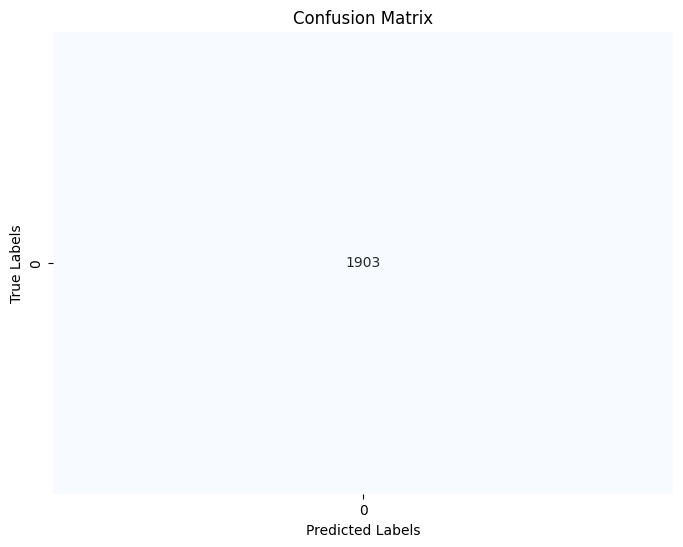

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903

    accuracy                           1.00      1903
   macro avg       1.00      1.00      1.00      1903
weighted avg       1.00      1.00      1.00      1903



In [5]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes)
print('Classification Report:')
print(class_report)